In [1]:
#pip install sklearn

In [2]:
#pip install transformers

In [3]:
#pip install tensorflow

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
import tempfile

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler

from tensorflow import keras, feature_column
from tensorflow.keras import layers
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
# Последовательная модель НС
from tensorflow.keras.models import Sequential  
# Основные слои
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization 
# Утилиты для to_categorical()
from tensorflow.keras import utils   
# Алгоритмы оптимизации для обучения модели
from tensorflow.keras.optimizers import Adam, Adadelta   
# Связь с google-диском
#from google.colab import files   
# Предварительная обработка данных
from sklearn import preprocessing                 

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

file_path = 'chd_addmit_300.xlsx'
# удаляем даты
dataframe = pd.read_excel(file_path).drop(['birth','admittion',	'discharge', 'Дата опер.'], axis=1)


# Предобработка

In [5]:
# англофикация названий признаков. Необходимо для сохранения модели
count = 0
data = dataframe.copy()
for col in data.drop('target', axis=1).columns:
    data = data.rename(columns={col: f"col_{count}"})
    count += 1
    
dataframe = data

# Вспомогательный метод для создания tf.data dataset из датафрейма Pandas
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Делаем заглушки
for col in dataframe.columns.tolist():
  if dataframe[col].dtypes in ['float64', 'int64']:
    dataframe[col] = dataframe[col].fillna(dataframe[col].median())

for col in dataframe.columns.tolist():
  if dataframe[col].dtypes == 'object':
    dataframe[col] = dataframe[col].fillna('Нет данных')
    

В тесте используем всю таблицу без разделения. Т.к. модель готовая и в обучении не нуждается.

In [14]:
batch_size = 256
ds = df_to_dataset(dataframe, shuffle=False, batch_size=batch_size)
y_test = dataframe['target']

C:\Users\dtata\AppData\Local\Temp/ipykernel_11448/2258536181.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [10]:
# предобработка слоя с числовыми призанками
def get_normalization_layer(name, dataset):
  # Создаем слой нормализации для объекта.
  normalizer = layers.Normalization(axis=None)
  # Подготовка набора данных, который дает только этот признак.
  feature_ds = dataset.map(lambda x, y: x[name])
  # Обучить статистику данных.
  normalizer.adapt(feature_ds)
  return normalizer

# предобработка слоя с категориальными призанками
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Создайтся слой, который превращает строки в целые индексы.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # В противном случае создайтся слой, который превращает целые значения в целые индексы.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)
  # Подготовка `tf.data.Dataset`, который дает только этот признак.
  feature_ds = dataset.map(lambda x, y: x[name])
  # Изучить набор возможных значений и присвоить им фиксированный целочисленный индекс.
  index.adapt(feature_ds)
  # Кодировать целочисленные индексы.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
  # Применить многократное горячее кодирование к индексам. Лямбда-функция захватывает слои,
  # чтобы вы могли использовать их или позже включить в функциональную модель Keras.
  return lambda feature: encoder(index(feature))

all_inputs = [] # inputs
encoded_features = [] # output

# Numerical features.
for header in dataframe.columns.tolist():
  if dataframe[header].dtypes in ['float64', 'int64']:
    # inputs
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    # output
    normalization_layer = get_normalization_layer(header, ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    # append
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

# Сategorical features.
categorical_cols = dataframe.loc[:,dataframe.dtypes == 'object'].columns.tolist()
for header in categorical_cols:
    # inputs
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # output
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=ds,
                                                dtype='string',
                                                max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    # append
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)


# Тест на всей таблице

In [12]:
# загрузить модель из папки
from keras.models import load_model
model = load_model('VPS_by_kids_NLP_model')


2/2 [==============================] - 0s 5ms/step


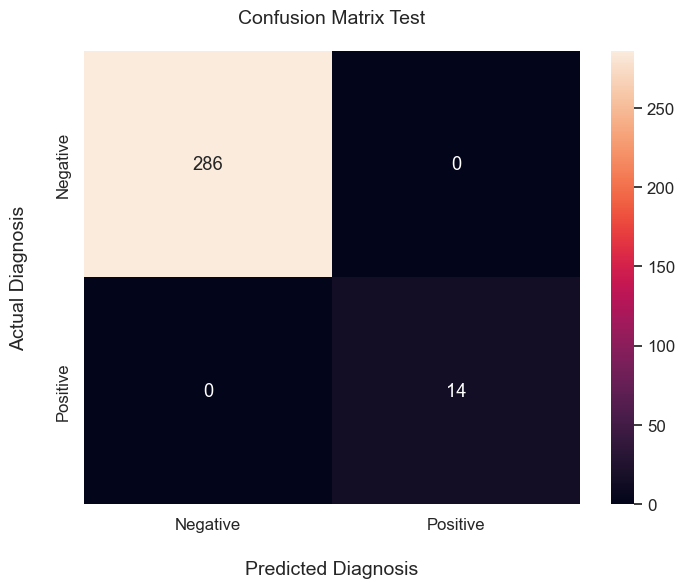

recall_score: 1.00
precision_score: 1.00


In [16]:
# предобработка результата
predict_proba_one = np.array(pd.Series([x[0] for x in model.predict(test_ds)]), 'float32')
y_pred = np.array(pd.Series([1 if x[0]>0.5 else 0 for x in model.predict(test_ds)]), 'int64')
y_test.reset_index(drop=True)

# проверим модель на эффективность. Выводим матрицу ошибок
plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', )
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_title("Confusion Matrix Test", fontsize=14, pad=20)
plt.show()

print("recall_score: %.2f" % recall_score(y_test, y_pred))
print("precision_score: %.2f" % precision_score(y_test, y_pred))
